In [ ]:
# @title Imports

# General
import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib as mpl
from matplotlib import pyplot as plt
import random
from statistics import mean

# Deep learning
import torch
from torch import nn, optim
from torchvision import transforms

# Images
import PIL.Image as Image
import cv2
import imageio

# # Response visualizations
# !pip install umap-learn
# import umap

# Set random seeds for reproducibility
np.random.seed(12)
torch.manual_seed(12)

In [ ]:
# @title Helper Functions


def get_hidden_activity(net, stimuli, layer_labels):
  """Retrieve internal representations of network

  Args:
    net (nn.Module): deep network
    stimuli (torch.Tensor): input to the network
    layer_labels (list): list of strings with labels of each layer for which
      to return its internal representations

  Returns:
    dict: internal representations at each layer of the network, in
      numpy arrays. The keys of this dict are the strings in layer_labels.

  """

  hidden_activity = {}

  # Attach hooks to each layer of the network to store hidden
  # representations in hidden_activity
  def hook(module, input, output):
    module_label = list(net._modules.keys())[np.argwhere([module == m for m in net._modules.values()])[0, 0]]
    if module_label in layer_labels:
      hidden_activity[module_label] = output.view(stimuli.shape[0], -1).cpu().detach().numpy()
  hooks = [layer.register_forward_hook(hook) for layer in net.children()]

  # Run stimuli through the network
  pred = net.predict(stimuli)

  # Remove the hooks
  [h.remove() for h in hooks]

  return hidden_activity

def get_probabilities(difficulty=None, one_stim=False):

  # Defaults
  NoGo = .2         # Probability of NoGo
  OneStim = .2      # Probability of one stimulus: set to 1 if want all 1 stim data

  diff_0 = .2       # Probability of intensity difference = 0
  diff_25 = .2      # Probability of intensity difference = .25
  diff_50 = .1      # Probability of intensity difference = .50
  diff_75 = .1      # Probability of intensity difference = .75
  diff_1 = .2       # Probability of intensity difference = 1

  probabilities = [NoGo, OneStim, diff_0, diff_25, diff_50, diff_75, diff_1]

  return probabilities

def get_resp_layer_labels(net):
  layer_names = ['conv1', 'pool1', 'conv2', 'pool2', 'finalpool', 'fc1', 'fc2', 'out']
  # layer_names = list(net._modules.keys())
  return layer_names

def get_unique_labels(multiple=1, cast=None, alt=None, diff=False):

  intensities = [0., .25, .50, .75, 1.] # Adding .75 just for fun
  labels = []

  for intens1 in intensities:
    for intens2 in intensities:
      case = [intens1,0.,intens2]
      if cast=='strings': case = str([intens1,intens2])
      labels.extend([case]*multiple)

  return labels

# def resp_label_remap():

#   labels = get_unique_labels()
#   for i, label in enumerate(labels):

def get_resp_layer_inputs(labels=None, diff=False, alt=None):

  # Labels for each of the cases
  if not labels:
    labels = get_unique_labels(multiple=4,diff=diff)

  data = pd.DataFrame(columns=['stimulus', 'label'])
  for label in labels:
    image, _, _ = generate_image(label)
    norm_transform = transforms.ToTensor()
    image_norm = norm_transform(image)
    new_row = pd.DataFrame([[image_norm, label]], columns=['stimulus', 'label'])
    data = pd.concat([data, new_row], ignore_index=True)

  resp_stimuli = torch.stack([data['stimulus'][i].to(torch.float32) for i in range(len(labels))])
  resp_labels = torch.from_numpy(np.array(labels)).type(torch.float).unsqueeze(-1)
  resp_labels = torch.reshape(resp_labels,(len(labels),3))

  if torch.cuda.is_available():
    resp_stimuli = resp_stimuli.to('cuda')
    resp_labels = resp_labels.to('cuda')
  return resp_stimuli

def run_UMAP(responses, label, len_col=16):

  # # Response visualizations
  !pip install umap-learn
  import umap

  colors = []
  for i in range(len_col):
    colors.extend([i]*4)
  colors2 = [color/25 for color in colors]
  color_map = plt.cm.get_cmap('viridis')
  colors_viridis = color_map(colors2)

  images = []
  for resp in responses:
    fig, ax = plt.subplots()
    ax.set_title(f'{label} layer responses')

    resp_lowd = umap.UMAP(random_state=42, min_dist=0.4, n_neighbors=15).fit_transform(resp)
    labels = get_unique_labels(cast='strings')

    x, y = resp_lowd[:, 0], resp_lowd[:, 1]
    pts = ax.scatter(x, y, c=colors, cmap='viridis', vmin=min(colors), vmax=max(colors))
    fig.colorbar(pts, ax=ax, ticks=np.linspace(min(colors), max(colors), 4),
                  label='Stimulus')

    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig('/content/test.png')

    plt.close()
    image_file = Image.open('/content/test.png')
    image = np.asarray(image_file)
    images.append(image)
  return images

def make_gif(embeddings, title: str):
  embedding_images = []
  for mat in embeddings:#[0::2]:
      image = Image.fromarray(mat)
      embedding_images.extend([image]*7)
  imageio.mimsave(f'/content/{title}.gif', embedding_images)

In [ ]:
# @title Generate Data

def generate_image(label, width: int=902, height: int=600, radius_interval: tuple=(40,50)) -> tuple:
  '''
    label: Array-like with length 3. Specifies intensity of image on each screen.
           Possible values: {0, .25, .5, 1}
    width: Image width in pixels
    height: Image height in pixels
    radius_interval: Range of stimulus radii to be used by random generator
  '''

  def draw_circle(image, center_x, center_y, radius, intensity):
    cv2.circle(image, (center_x, center_y), radius, intensity, -1)

    # Gabor Effect
    start_point = (center_x, center_y - radius)
    end_point = (center_x - radius, center_y)
    cv2.line(image, start_point, end_point, 255, radius*2//5)

    start_point = (center_x + radius, center_y)
    end_point = (center_x, center_y + radius)
    cv2.line(image, start_point, end_point, 255, radius*2//5)

    start_point = (center_x + int(np.sqrt(2) / 2 * radius), center_y - int(np.sqrt(2) / 2 * radius))
    end_point = (center_x - int(np.sqrt(2) / 2 * radius), center_y + int(np.sqrt(2) / 2 * radius))
    cv2.line(image, start_point, end_point, 255, radius*2//5)

    return image

  # Adjust label vector to account for intensity of 255 not working
  label_original = label.copy()
  label = [.999 if intensity == 1 else intensity for intensity in label]

  # Initialize canvas
  image = np.zeros((height, width, 1), dtype=np.uint8) + 255

  # Control param for thickness used throughout
  thickness = 1

  # Screen Split lines
  start_point1 = ((width-2) // 3, 0)
  end_point1 = ((width-2) // 3, 599)
  start_point2 = (2 * (width-2) // 3, 0)
  end_point2 = (2 * (width-2) // 3, 599)

  color = 0 # Color of center split line
  cv2.line(image, start_point1, end_point1, color, thickness)
  cv2.line(image, start_point2, end_point2, color, thickness)


  # Generate left circle
  intensity_left = 255*(1-label[0])
  if intensity_left:
    radius_left = 100 #np.random.randint(radius_interval[0], radius_interval[1])
    center_x_left = 150 #np.random.randint(radius_left, (width-2)//3 - 1 - radius_left)
    center_y_left = 300 #np.random.randint(radius_left, height - 1 - radius_left)
    image = draw_circle(image, center_x_left, center_y_left, radius_left, intensity_left)
  else: radius_left, center_x_left, center_y_left = None, None, None


  # Generate right circle
  intensity_right = 255*(1-label[2])
  if intensity_right:
    radius_right = 100 #np.random.randint(radius_interval[0], radius_interval[1])
    center_x_right = 750 #np.random.randint(2 * (width-2) // 3  + radius_right, (width-2) - radius_right)
    center_y_right = 300 #np.random.randint(radius_right, height - 1 - radius_right)
    image = draw_circle(image, center_x_right, center_y_right, radius_right, intensity_right)
  else: radius_right, center_x_right, center_y_right = None, None, None

  stim_coords = [(radius_left, center_x_left, center_y_left), (radius_right, center_x_right, center_y_right)]

  return (image, label_original, stim_coords)

def get_batch(batch_size: int, probabilities, image_gen_params: tuple=(902,600,(40,50))):
  '''
    size: Desired dataset size
    probabilities: Array-like of length 7. Controls probabilities of different
    conditions. Indices: [Go/NoGo, OneStim, diff=0, diff=.25, diff=.5, diff=.75, diff=1]
  '''

  width, height, radius_interval = image_gen_params

  def get_labels(batch_size: int, probabilities):

    # Possible intensity difference conditions in case of Go trial
    intensity_diffs = [0, .25, .5, .75, 1]

    # Possible combinations given an intensity difference in two stim case
    intensities_dict = {
        0 : [[ 0.25 ]*2, [ 0.5 ]*2, [ 1.0 ]*2],
      .25 : [[ 0.25, 0.5 ]],
        .5 : [[ 0.5, 1.0 ]],
      .75 : [[ 0.25, 1.0 ]]
    }

    # Generate labels
    labels = []

    for i in range(batch_size):
      # Initialize label
      label = [0]*3

      # With Bern. probability proportionate to desired chance of NoGo, end here
      if np.random.binomial(1, probabilities[0], 1):
        labels.append(label)
        continue

      # Choose Right=2 Left=0 with equal probability
      side_index = 2 if np.random.binomial(1, 0.5, 1) else 0

      # Decide on one or two stims (one stimulus is easier)
      n_stims = 1 if np.random.binomial(1, probabilities[1], 1) else 2

      # One stimulus case
      if n_stims == 1:
        # Weighted choice of intensity difference condition
        intensity_diff = random.choices(intensity_diffs, weights=probabilities[2:])[0]
        label[side_index] = intensity_diff
        labels.append(label)

      # Two stimuli case
      else:
        # Weighted choice of intensity difference condition (1 is not possible)
        intensity_diff = random.choices(intensity_diffs[:-1], weights=probabilities[2:-1])[0]

        # Choose Left and Right intensities
        values = intensities_dict[intensity_diff][random.choice(range(len(intensities_dict[intensity_diff])))]

        # Note: (side_index + 2) % 4 gives the other index, i.e. if side_index
        # is 0 (Left) this will return 2 (Right), and vice versa
        label[side_index], label[(side_index + 2) % 4] = values[0], values[1]
        labels.append(label)

    return labels

  labels = get_labels(batch_size, probabilities)
  data = pd.DataFrame(columns=['stimulus', 'label'])#, 'coordinates'])
  for label in labels:
    image, label, coords = generate_image(label, width, height, radius_interval)
    # image_res = cv2.resize(image, dsize=(226, 150), interpolation=cv2.INTER_LINEAR)
    norm_transform = transforms.ToTensor()
    image_norm = norm_transform(image)
    new_row = pd.DataFrame([[image_norm, label]], columns=['stimulus', 'label'])#, 'coordinates'])
    data = pd.concat([data, new_row], ignore_index=True)

  stimuli = torch.stack([data['stimulus'][i].to(torch.float32) for i in range(batch_size)])#, device=torch.device('cuda'))
  # stimuli = torch.reshape(stimuli, (size, 226, 150))
  labels = torch.from_numpy(np.array(labels)).type(torch.float).unsqueeze(-1)
  labels = torch.reshape(labels,(batch_size,3))

  if torch.cuda.is_available():
    stimuli = stimuli.to('cuda')
    labels = labels.to('cuda')

  return stimuli, labels

In [ ]:
from scipy.stats.distributions import truncexpon
#@title VGG Lite

# Based on VGG16 architecture
class CNN(nn.Module):
    def __init__(self, num_screens=3):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        # if self.training:
        #   self.fc = nn.Sequential(
        #       nn.Dropout(0.5),
        #       nn.Linear(2240, 2240),
        #       nn.ReLU())
        #   self.fc1 = nn.Sequential(
        #       nn.Dropout(0.5),
        #       nn.Linear(2240, 1000),
        #       nn.ReLU())
        # else:
        self.fc1 = nn.Sequential(
            nn.Linear(2240, 2240, bias=False),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(2240, 1000, bias=False),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(1000, num_screens, bias=True))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    # Use to disable training of weights during model evaluation
    def train(self, mode: bool = True):
      self.training = mode
      for module in self.children():
          module.train(mode)
      return self


    def train_loop(net, probabilities, dataset_size=1000,
          n_epochs=25, learning_rate=0.0005,
          batch_size=100, momentum=.99, resp_viz=False):

      # Initialize L1 loss function
      loss_fn = nn.SmoothL1Loss()

      # Initialize SGD optimizer with momentum
      optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

      # Placeholder to save loss at each iteration
      track_loss = []

      # Initialize response dictionary and inputs
      if resp_viz:
        resp_layer_labels = get_resp_layer_labels(net)
        resp_dict = {layer : [] for layer in resp_layer_labels}
        stimuli_for_hooks = get_resp_layer_inputs()
      else: resp_dict = None

      # Loop over epochs
      for i in range(n_epochs):

        # Loop over number of batches
        for j in range(dataset_size//batch_size):

          stimuli, labels = get_batch(batch_size, probabilities)

          # Evaluate loss and update network weights
          out = net(stimuli)  # predicted
          loss = loss_fn(out, labels)  # evaluate loss
          optimizer.zero_grad()  # clear gradients
          loss.backward()  # compute gradients
          optimizer.step()  # update weights

          # Keep track of loss at each iteration
          track_loss.append(loss.item())

          # Update response dictionary
          if resp_viz:
            resp_model = get_hidden_activity(net, stimuli_for_hooks, resp_layer_labels)
            for layer in resp_layer_labels:
              resp_dict[layer].append(resp_model[layer])

        # Track progress
        if (i + 1) % (n_epochs // 5) == 0:
          print(f'epoch {i + 1} | loss on last batch: {round(loss.item(),3)}')#: .3}')

      print('training done!')

      return track_loss, resp_dict

    def evaluate(net, test_dataset_size, probabilities):

      with torch.no_grad():
        # Set model to eval mode
        net.train(False)

        # Initialize L1 loss function
        loss_fn = nn.SmoothL1Loss()

        # Placeholder to save loss for each batch
        track_loss = []

        # Loop over number of batches
        for j in range(dataset_size//batch_size):

          stimuli, labels = get_batch(batch_size, probabilities)
          out = net(stimuli)
          loss = loss_fn(out, labels)

          # Keep track of loss
          track_loss.append(loss.item())

      return mean(track_loss)

    def predict(net, stimuli):

      with torch.no_grad():
        # Set model to eval mode
        net.train(False)
        out = net(stimuli)

      return out

In [ ]:
#@title TinyAlexNet
# Final model used

from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn
from torchsummary import summary

from torchvision.utils import _log_api_usage_once
from torchvision.transforms import Resize

__all__ = ["TinyAlexNet", "TinyAlexNet_Weights", "tinyalexnet"]


class TinyAlexNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        _log_api_usage_once(self)
        # self.resize = Resize((226, 150))
        self.conv1 = nn.Conv2d(1, 16, kernel_size=11, stride=4, padding=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(16, 16, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.finalpool = nn.MaxPool2d((4,4))

        self.fc1 = nn.Linear(1872, 100) #384 #6144
        self.fc2 = nn.Linear(100, 100)
        self.out = nn.Linear(100, 3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.finalpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x


    # Used to disable training of weights during model evaluation
    def train(self, mode: bool = True):
      self.training = mode
      for module in self.children():
          module.train(mode)
      return self


    def train_loop(net, probabilities, dataset_size=1000,
          n_epochs=25, learning_rate=0.0005,
          batch_size=100, momentum=.99, resp_viz=False):

      # Initialize L1 loss function
      loss_fn = nn.SmoothL1Loss()

      # Initialize SGD optimizer with momentum
      optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

      # Placeholder to save loss at each iteration
      track_loss = []

      # Initialize response dictionary and inputs
      if resp_viz:
        resp_layer_labels = get_resp_layer_labels(net)
        resp_dict = {layer : [] for layer in resp_layer_labels}
        stimuli_for_hooks = get_resp_layer_inputs()
      else: resp_dict = None

      # Loop over epochs
      for i in range(n_epochs):

        # Loop over number of batches
        for j in range(dataset_size//batch_size):

          stimuli, labels = get_batch(batch_size, probabilities)

          # Evaluate loss and update network weights
          out = net(stimuli)  # predicted
          loss = loss_fn(out, labels)  # evaluate loss
          optimizer.zero_grad()  # clear gradients
          loss.backward()  # compute gradients
          optimizer.step()  # update weights

          # Keep track of loss at each iteration
          track_loss.append(loss.item())

        # Update response dictionary
        if resp_viz:
          if (i + 1) % (n_epochs // 50) == 0:
            resp_model = get_hidden_activity(net, stimuli_for_hooks, resp_layer_labels)
            for layer in resp_layer_labels:
              resp_dict[layer].append(resp_model[layer])

        # Track progress
        if (i + 1) % (n_epochs // 5) == 0:
          print(f'epoch {i + 1} | loss on last batch: {loss.item(): 3e}')#: .3}')

      print('training done!')

      return track_loss, resp_dict

    def evaluate(net, test_dataset_size, probabilities):

      with torch.no_grad():
        # Set model to eval mode
        net.train(False)

        # Initialize L1 loss function
        loss_fn = nn.SmoothL1Loss()

        # Placeholder to save loss for each batch
        track_loss = []

        # Loop over number of batches
        for j in range(dataset_size//batch_size):

          stimuli, labels = get_batch(batch_size, probabilities)
          out = net(stimuli)
          loss = loss_fn(out, labels)

          # Keep track of loss
          track_loss.append(loss.item())

      return mean(track_loss)

    def predict(net, stimuli):

      with torch.no_grad():
        # Set model to eval mode
        net.train(False)
        out = net(stimuli)

      return out

In [ ]:
def get_probabilities(difficulty=None, one_stim=False):

  # Defaults
  NoGo = .2         # Probability of NoGo
  OneStim = .5      # Probability of one stimulus: set to 1 if want all 1 stim data

  diff_0 = .2       # Probability of intensity difference = 0
  diff_25 = .2      # Probability of intensity difference = .25
  diff_50 = .2      # Probability of intensity difference = .50
  diff_75 = .2      # Probability of intensity difference = .75
  diff_1 = .2       # Probability of intensity difference = 1

  probabilities = [NoGo, OneStim, diff_0, diff_25, diff_50, diff_75, diff_1]

  return probabilities

epoch 20 | loss on last batch:  2.492978e-02
epoch 40 | loss on last batch:  4.519762e-03
epoch 60 | loss on last batch:  4.866392e-04
epoch 80 | loss on last batch:  7.999821e-05
epoch 100 | loss on last batch:  2.263759e-05
training done!


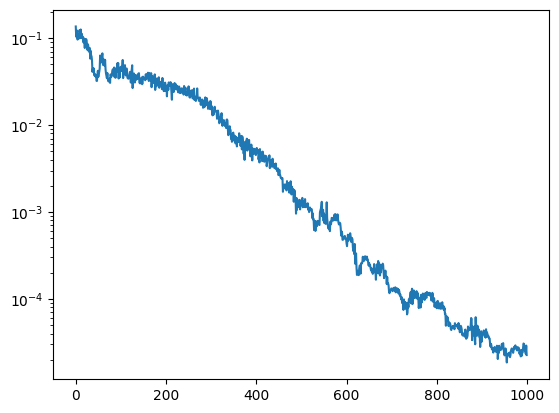

In [ ]:
#@title Train CNN

# Parameters
n_epochs = 100
batch_size = 100
dataset_size = 1000

# Original AlexNet: 50 epochs
# Small AlexNet (three conv): 200 epochs
# TinyAlexNet (two conv): 100 epochs
# To run TinyAlexNet with more complicated images: ~300 epochs?
net = TinyAlexNet()
if torch.cuda.is_available():
    net.to('cuda')

probabilities = get_probabilities()
losses, resp_dict = TinyAlexNet.train_loop(net,
                              probabilities=probabilities,
                              dataset_size=dataset_size,
                              n_epochs=n_epochs,
                              batch_size=batch_size, resp_viz=False)
                            # Set resp_viz to True for visualizations
                            # Warning: visualization is RAM-hungry and takes time

plt.yscale('log')
plt.plot(losses)
plt.title('Smooth L1 Loss (log scale)')
plt.show()

In [ ]:
test_size = 1000

test_loss = CNN.evaluate(net, test_size, probabilities)

print(f'CNN average test loss (L1): {test_loss: .2}')

CNN average test loss (L1):  3.1e-05


In [ ]:
test_size = 1000
stimuli_test, labels_test = get_batch(test_size, probabilities)

In [ ]:
net.predict(stimuli_test[10:20])

tensor([[ 3.7469e-03, -5.2970e-04,  2.4481e-01],
        [ 1.0194e+00,  1.8578e-03,  1.0149e+00],
        [ 2.4271e-01, -1.1744e-03,  4.8330e-03],
        [ 4.4952e-03, -4.8647e-04,  7.3624e-01],
        [ 4.1877e-03, -7.3332e-04,  4.8515e-01],
        [ 2.3172e-03, -4.2504e-04,  3.2194e-03],
        [ 4.8616e-01, -9.8563e-04,  2.4596e-01],
        [ 4.1877e-03, -7.3332e-04,  4.8515e-01],
        [ 2.4725e-01, -1.2561e-03,  1.0160e+00],
        [ 1.0163e+00,  1.8349e-03,  2.4539e-01]], device='cuda:0')

In [ ]:
labels_test[10:20]

tensor([[0.0000, 0.0000, 0.2500],
        [1.0000, 0.0000, 1.0000],
        [0.2500, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7500],
        [0.0000, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000],
        [0.5000, 0.0000, 0.2500],
        [0.0000, 0.0000, 0.5000],
        [0.2500, 0.0000, 1.0000],
        [1.0000, 0.0000, 0.2500]], device='cuda:0')

Simple images work best; more complicated images work as well but will take longer to train on and may exhibit less friendly errors in the predicted labels (but it worked all right on most trials). I recommend sticking to simpler images closer to the experiment.

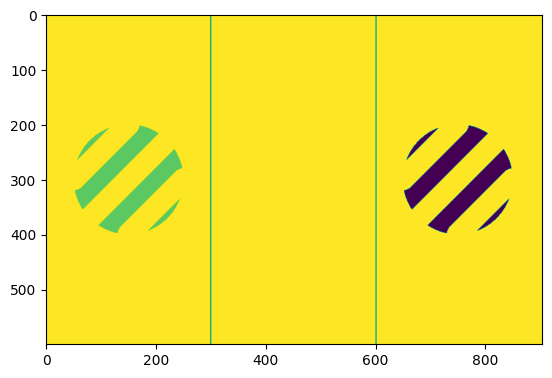

In [ ]:
plt.imshow(stimuli_test[10].cpu().detach().numpy().reshape((600,902)))
plt.show()

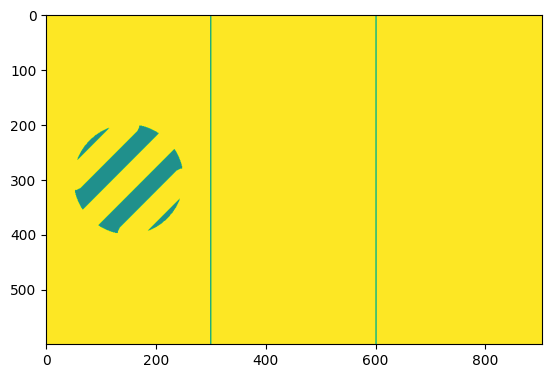

In [ ]:
plt.imshow(stimuli_test[14].cpu().detach().numpy().reshape((600,902)))
plt.show()

In [ ]:
#@title Visualization

UMAP_conv1 = run_UMAP(resp_dict['conv1'], 'Conv 1')
UMAP_conv2 = run_UMAP(resp_dict['conv2'], 'Conv 2')
UMAP_pool1 = run_UMAP(resp_dict['pool1'], 'Pool 1')
UMAP_pool2 = run_UMAP(resp_dict['pool2'], 'Pool 2')
UMAP_finalpool = run_UMAP(resp_dict['finalpool'], 'Last Pool')
UMAP_fc1 = run_UMAP(resp_dict['fc1'], 'FC 1')
UMAP_fc2 = run_UMAP(resp_dict['fc2'], 'FC 2')
UMAP_out = run_UMAP(resp_dict['out'], 'Output')

for layer_images, img_title_str in zip([UMAP_conv1, UMAP_conv2, UMAP_pool1, UMAP_pool2, UMAP_finalpool, UMAP_fc1, UMAP_fc2, UMAP_out],
                              ['Conv1', 'Conv2', 'Pool1', 'Pool2', 'LastPool', 'FC1', 'FC2', 'Output']):

# Make a GIF of UMAP over the learning process
make_gif(layer_images, img_title_str)

Example visualizations (I will add labels today to get a better sense of which inputs are being grouped together).

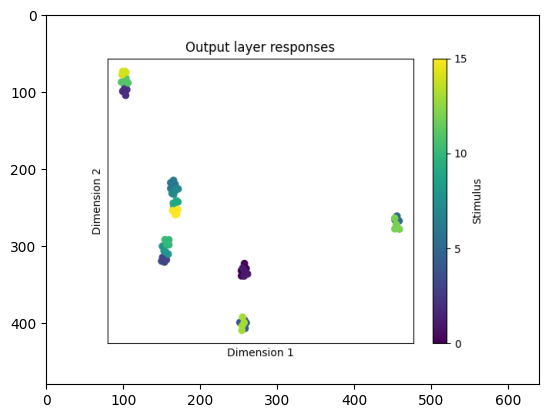

In [ ]:
plt.imshow(UMAP_out[-1])
plt.show()

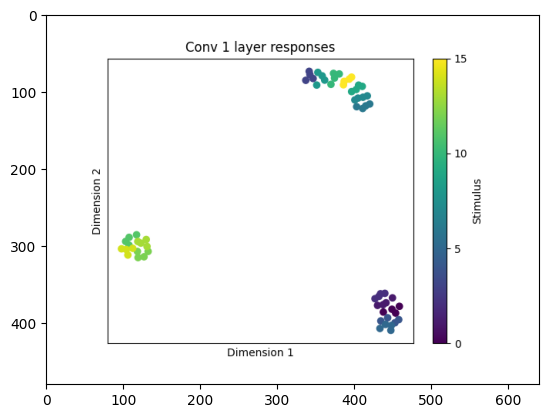

In [ ]:
plt.imshow(UMAP_conv1[-1])
plt.show()

In [ ]:
# #@title # How to connect with RL:

# # Generate a random input image (batch size of 1)
# environment_image_input, _ = get_batch(batch_size=1, probabilities=probabilities)

# # Get predicted intensities
# obs = net.predict(environment_image_input).cpu().detach().numpy()
# # Need to append the two additional dimensions used by RL